# Business Objective
Earthquakes around the world cause significant damage to property and loss of lives. The objective of this project is, for a given location, predicting how much damage a structure sustain for a nearby earthquake scenario. We will use Peak Ground Acceleration (PGA) as a metric to approximate damage as these two are very closely correlated.

Before making investment in buildings and critical infrastructure, earthquake risk should be assessed for the particular area to minimize loss in the event of an earthquake. Otherwise, investments can be lost in a catastrophic earthquake event. This model can be used by public authorities prior to providing permits for a building or by private entities before making investment decisions. Also it can be utilized by insurance companies to asses risk.


# Import Libraries

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import math

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, auc, RocCurveDisplay, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

# Data Understanding and Preparation
Dataset comes from Pacific Earthquake Engineering Research Center. https://apps.peer.berkeley.edu/ngawest/nga_flatfiles.html

Dataset includes seismograph measurements of 600 earhquakes around the world, from 1935 to 2011. Each earthquake is measured by multiple stations. In total there are 21539 measurements in the dataset.

## Data Features

Each measurement has 274 columns. Because of the high number of columns, we will only summarize columns are  potentially useful for analysis.

- Record Sequence Number: Unique identifier for each record in the dataset
- EQID: ID if the earthquake
- Earthquake Name: Name of the earthquake
- YEAR: Year of the earthquake
- MODY: Month and day of the earthqyake
- Station Name: Short name of the station measuring the earthquake
- Earthquake Magnitude: Magnitude of the earquake in Richter scale
- Vs30 (m/s) selected for analysis: Vs30 of the ground implying the material type. Speed of the wave at 30meters depth.
- PGA (g): Peak ground acceleration. This is used as the target variable
- Strike (deg): Direction of the fault relative to North
- Dip (deg): Angle of the fault relative to horizontal
- Rake Angle (deg)': Direction of fault motion with respect to the strike
- Hypocenter Latitude (deg)'
- Hypocenter Longitude (deg)'
- Hypocenter Depth (km)': Depth of the earthquake at hypocenter
- Depth to Top Of Fault Rupture Model': Distance from the surface to the rupture plane
- Fault Rupture Width (km)': Width of the rupture
- Fault Rupture Area (km^2)': Area of the rupture
- EpiD (km)': Distance to epicenter
- HypD (km)': Distance to hypocenter
- ClstD (km)': Closest distance between site to the rupture
- Vs30 (m/s) selected for analysis': Shear wave velocity at 30 meters of the soil
- Station Latitude'
- Station Longitude',
- PGA (g)': Peak ground acceleration. This is the target variable that predicts magnitude of the shake at a given location

In [80]:
#load raw data
raw = pd.read_excel('data/earthquake.xlsx', sheet_name='ROTD50_d005', engine='openpyxl')

In [81]:
raw

,Record Sequence Number,EQID,Earthquake Name,YEAR,MODY,HRMN,Station Name,Station Sequence Number,Station ID No.,Earthquake Magnitude,...,Instrument Nat. Freq.,Instrument Damping,Instrument Type,Quality_Flag,Spectra Quality Flag,Late S-trigger,Late P-trigger,Idirectivity,Tp,Ry 2
0,1,1.0,"Helena, Montana-01",1935.0,1031.0,1838.0,Carroll College,197.0,2022,6.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,8.046386
1,2,2.0,"Helena, Montana-02",1935.0,1031.0,1918.0,Helena Fed Bldg,198.0,2229,6.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.155745
2,3,3.0,Humbolt Bay,1937.0,207.0,442.0,Ferndale City Hall,133.0,1023,5.8,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,-38.820722
3,4,4.0,Imperial Valley-01,1938.0,606.0,242.0,El Centro Array #9,75.0,117,5.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,23.958844
4,5,5.0,Northwest Calif-01,1938.0,912.0,610.0,Ferndale City Hall,133.0,1023,5.5,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,51.112544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,21535,1265.0,51177103,2006.0,1223.0,649.0,"Jasper Ridge Biol. Preserve, Stanford, CA, USA",100506.0,JRSC,3.6,...,0.0083,0.7071,v,NaN,0.0,NaN,NaN,NaN,NaN,NaN
21535,21536,1265.0,51177103,2006.0,1223.0,649.0,San Andreas Cal.,100433.0,JSA,3.6,...,223.9758,0.6971,a,NaN,0.0,NaN,NaN,NaN,NaN,NaN
21536,21537,1265.0,51177103,2006.0,1223.0,649.0,Stanford Telescope,100448.0,JSFB,3.6,...,223.9758,0.6971,a,NaN,0.0,NaN,NaN,NaN,NaN,NaN
21537,21538,1265.0,51177103,2006.0,1223.0,649.0,San Pedro Valley,100331.0,JSP,3.6,...,223.9758,0.6971,a,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [82]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21539 entries, 0 to 21538
Columns: 274 entries, Record Sequence Number to Ry 2
dtypes: float64(230), int64(1), object(43)
memory usage: 45.0+ MB


In [83]:
raw.describe()

,Record Sequence Number,EQID,YEAR,MODY,HRMN,Station Sequence Number,Earthquake Magnitude,Magnitude Uncertainty: Kagan Model,Magnitude Uncertainty: Statistical,Magnitude Sample Size,...,XCI1,Damping (%),RotD percentile,Instrument Nat. Freq.,Instrument Damping,Quality_Flag,Spectra Quality Flag,Idirectivity,Tp,Ry 2
count,21539.00000,21528.000000,21528.000000,21528.000000,20099.000000,21517.000000,21527.000000,4210.000000,2150.000000,2280.000000,...,6029.000000,21539.0,21528.0,12943.000000,12943.000000,10790.000000,21528.000000,8604.000000,149.000000,21190.000000
mean,10770.00000,734.088907,2003.450019,688.355723,1202.481716,50350.844495,4.957009,0.086181,0.092101,7.298246,...,0.011898,0.5,50.0,132.200301,0.690121,0.011677,0.007850,0.017318,4.836440,6.338589
std,6217.91806,441.119623,6.498458,316.279000,722.860964,49196.308601,1.263509,0.027767,0.074586,3.951283,...,0.164623,0.0,0.0,218.294930,0.080926,0.134965,0.105075,0.130459,3.444978,130.971534
min,1.00000,1.000000,1935.000000,106.000000,0.000000,1.000000,2.990000,0.081000,0.000000,2.000000,...,-0.616100,0.5,50.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.322000,-1461.400100
25%,5385.50000,180.000000,2001.000000,502.000000,602.000000,1924.000000,3.900000,0.081000,0.043000,3.000000,...,-0.077400,0.5,50.0,0.008333,0.697100,0.000000,0.000000,0.000000,1.554000,-53.177672
50%,10770.00000,1018.000000,2005.000000,716.000000,1158.000000,3630.000000,4.500000,0.081000,0.070000,8.000000,...,-0.002100,0.5,50.0,49.990100,0.707000,0.000000,0.000000,0.000000,4.417000,5.810415
75%,16154.50000,1096.000000,2008.000000,925.000000,1842.000000,100183.000000,6.200000,0.081000,0.108000,9.000000,...,0.104300,0.5,50.0,216.000000,0.707000,0.000000,0.000000,0.000000,7.826000,67.943328
max,21539.00000,1266.000000,2011.000000,1229.000000,2359.000000,100630.000000,7.900000,0.300000,0.521000,15.000000,...,0.728600,0.5,50.0,900.091200,0.933600,2.000000,2.000000,1.000000,13.118000,814.239107


In [84]:
#number of earthquakes
len(raw['EQID'].unique())

600

## Missing Values

In [85]:
#print number of null values for each column to csv for easier visualization
raw.isna().sum().to_csv('usable columns.csv')

## Data Preperation

In [86]:
#based on the information gathered so far, load a subset of the data
#these are the columns with the least amount of missing values and selected as potentially useful for our analysis
raw_selected_columns = [
    'Record Sequence Number',
    'EQID',
    'Earthquake Name',
    'YEAR',
    'MODY',
    'Station Name',
    'Earthquake Magnitude',
    'Strike (deg)',
    'Dip (deg)',
    'Rake Angle (deg)',
    'Hypocenter Latitude (deg)',
    'Hypocenter Longitude (deg)',
    'Hypocenter Depth (km)',
    'Depth to Top Of Fault Rupture Model',
    'Fault Rupture Width (km)',
    'Fault Rupture Area (km^2)',
    'EpiD (km)',
    'HypD (km)',
    'ClstD (km)',
    'Vs30 (m/s) selected for analysis',
    'Station Latitude',
    'Station Longitude',
    'PGA (g)'
]

raw_selected = raw[raw_selected_columns]
raw_selected

,Record Sequence Number,EQID,Earthquake Name,YEAR,MODY,Station Name,Earthquake Magnitude,Strike (deg),Dip (deg),Rake Angle (deg),...,Depth to Top Of Fault Rupture Model,Fault Rupture Width (km),Fault Rupture Area (km^2),EpiD (km),HypD (km),ClstD (km),Vs30 (m/s) selected for analysis,Station Latitude,Station Longitude,PGA (g)
0,1,1.0,"Helena, Montana-01",1935.0,1031.0,Carroll College,6.0,268.0,75.0,160.0,...,1.974,4.2,68.1,6.31000,8.71000,2.86,593.35,46.5800,-112.0300,0.157020
1,2,2.0,"Helena, Montana-02",1935.0,1031.0,Helena Fed Bldg,6.0,268.0,75.0,160.0,...,2.039,7.9,120.0,6.31000,8.71000,2.92,551.82,46.5900,-112.0400,0.046423
2,3,3.0,Humbolt Bay,1937.0,207.0,Ferndale City Hall,5.8,196.2,90.0,0.0,...,6.449,8.3,74.3,73.49000,74.17000,71.57,219.31,40.5760,-124.2630,0.040961
3,4,4.0,Imperial Valley-01,1938.0,606.0,El Centro Array #9,5.0,205.5,90.0,0.0,...,13.082,3.8,8.4,33.20000,36.86000,34.98,213.44,32.7940,-115.5490,0.018449
4,5,5.0,Northwest Calif-01,1938.0,912.0,Ferndale City Hall,5.5,35.0,90.0,0.0,...,9.507,5.7,25.0,54.88000,55.78000,53.58,219.31,40.5760,-124.2630,0.122180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,21535,1265.0,51177103,2006.0,1223.0,"Jasper Ridge Biol. Preserve, Stanford, CA, USA",3.6,151.0,88.0,-177.0,...,7.920,0.8,0.8,50.68890,51.39086,51.11,391.55,37.4037,-122.2387,0.000397
21535,21536,1265.0,51177103,2006.0,1223.0,San Andreas Cal.,3.6,151.0,88.0,-177.0,...,7.920,0.8,0.8,34.87796,35.89050,35.63,723.35,37.5823,-122.4201,0.005030
21536,21537,1265.0,51177103,2006.0,1223.0,Stanford Telescope,3.6,151.0,88.0,-177.0,...,7.920,0.8,0.8,50.96330,51.66153,51.36,432.00,37.4037,-122.1760,0.000493
21537,21538,1265.0,51177103,2006.0,1223.0,San Pedro Valley,3.6,151.0,88.0,-177.0,...,7.920,0.8,0.8,38.41923,39.34073,39.13,535.12,37.5864,-122.5022,0.002952


In [87]:
raw_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21539 entries, 0 to 21538
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Record Sequence Number               21539 non-null  int64  
 1   EQID                                 21528 non-null  float64
 2   Earthquake Name                      21528 non-null  object 
 3   YEAR                                 21528 non-null  float64
 4   MODY                                 21528 non-null  float64
 5   Station Name                         21530 non-null  object 
 6   Earthquake Magnitude                 21527 non-null  float64
 7   Strike (deg)                         21502 non-null  float64
 8   Dip (deg)                            21502 non-null  float64
 9   Rake Angle (deg)                     21502 non-null  float64
 10  Hypocenter Latitude (deg)            21527 non-null  float64
 11  Hypocenter Longitude (deg)  

## Data Distribution

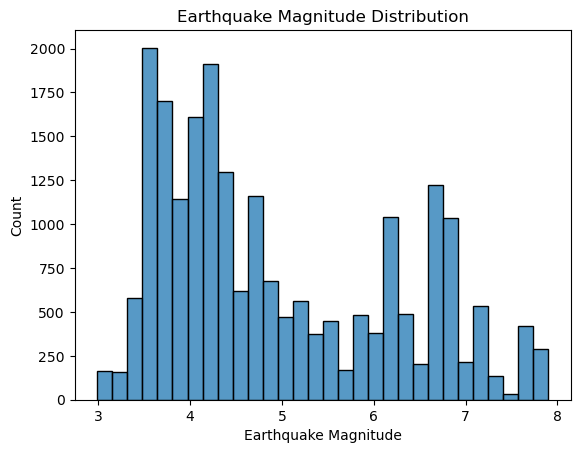

In [88]:
#a wide spectrum of earthquake magnitudes captured in the dataset
sns.histplot(data=raw_selected, x='Earthquake Magnitude').set(title='Earthquake Magnitude Distribution')
plt.savefig('images/mag_dist.png')

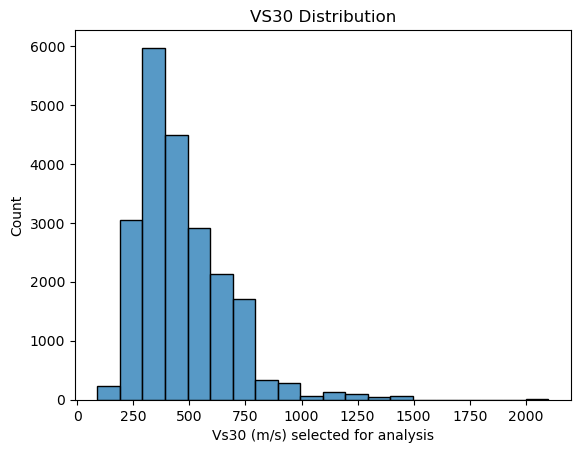

In [89]:
#VS30 implies the type of the ground (rock, soil, sand, etc) of the measuring stations.
#We have a wide range of VS30 values of stations to make meaningful analysis

sns.histplot(data=raw_selected, x='Vs30 (m/s) selected for analysis', bins=20).set(title='VS30 Distribution')
plt.savefig('images/vs30_dist.png')

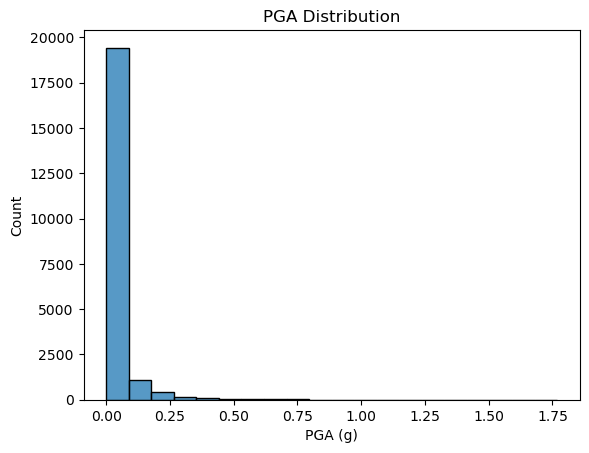

In [90]:
#majority of PGA values are close to zero. This may be because of stations being far to the epicenter
sns.histplot(data=raw_selected, x='PGA (g)', bins=20).set(title='PGA Distribution')
plt.savefig('images/pga_dist.png')

In [91]:
#identify outliers to find the PGA threshold. These are identified as outliers in terms of PGA.
#number of outliers is limited and can be taken out
raw_selected[(raw_selected['Earthquake Magnitude']>=6) & (raw_selected['EpiD (km)'] <= 50) & \
             (raw_selected['PGA (g)'] <= 0.05)]

,Record Sequence Number,EQID,Earthquake Name,YEAR,MODY,Station Name,Earthquake Magnitude,Strike (deg),Dip (deg),Rake Angle (deg),...,Depth to Top Of Fault Rupture Model,Fault Rupture Width (km),Fault Rupture Area (km^2),EpiD (km),HypD (km),ClstD (km),Vs30 (m/s) selected for analysis,Station Latitude,Station Longitude,PGA (g)
1,2,2.0,"Helena, Montana-02",1935.0,1031.0,Helena Fed Bldg,6.00,268.0,75.0,160.0,...,2.0390,7.9,120.0,6.31,8.71,2.92,551.82,46.5900,-112.0400,0.046423
268,269,64.0,"Victoria, Mexico",1980.0,609.0,Victoria Hospital Sotano,6.33,318.0,90.0,0.0,...,4.0000,10.0,300.0,11.79,16.13,7.27,242.05,32.2890,-115.1000,0.037313
294,295,69.0,"Irpinia, Italy-02",1980.0,1123.0,Auletta,6.20,124.0,70.0,-90.0,...,1.0000,10.1,151.5,37.15,37.81,29.86,476.62,40.5600,15.5580,0.023251
297,298,69.0,"Irpinia, Italy-02",1980.0,1123.0,Bovino,6.20,124.0,70.0,-90.0,...,1.0000,10.1,151.5,47.45,47.96,43.50,356.39,41.2510,15.5100,0.030015
300,301,69.0,"Irpinia, Italy-02",1980.0,1123.0,Mercato San Severino,6.20,124.0,70.0,-90.0,...,1.0000,10.1,151.5,48.19,48.70,44.41,428.57,40.7910,14.7640,0.043877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,4478,274.0,"L'Aquila, Italy",2009.0,406.0,Lab.Gran Sasso,6.30,139.0,48.0,-98.0,...,0.8000,16.0,320.0,18.75,20.92,11.15,547.00,42.4360,13.5540,0.022353
4484,4485,274.0,"L'Aquila, Italy",2009.0,406.0,Leonessa,6.30,139.0,48.0,-98.0,...,0.8000,16.0,320.0,41.07,42.10,35.95,649.67,42.5580,12.9690,0.008253
7086,7087,284.0,"Wenchuan, China-03",2008.0,512.0,Maoxiandiban,6.30,228.0,35.0,110.0,...,13.1324,13.0,149.5,43.26,46.82,41.65,638.39,31.7000,103.9000,0.045383
7089,7090,284.0,"Wenchuan, China-03",2008.0,512.0,Mianzuqingping,6.30,228.0,35.0,110.0,...,13.1324,13.0,149.5,43.26,46.82,38.81,551.30,31.5000,104.1000,0.017461


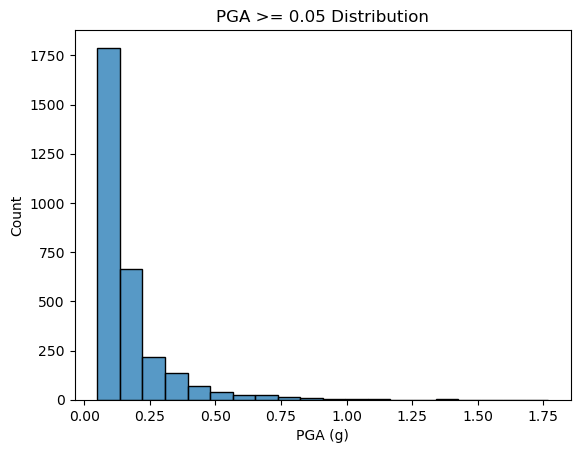

In [92]:
#consider filtering out <0.05g
sns.histplot(data=raw_selected[raw_selected['PGA (g)']>=0.05], x='PGA (g)', bins=20).set(title='PGA >= 0.05 Distribution')
plt.savefig('images/pga_0.05_dist.png')

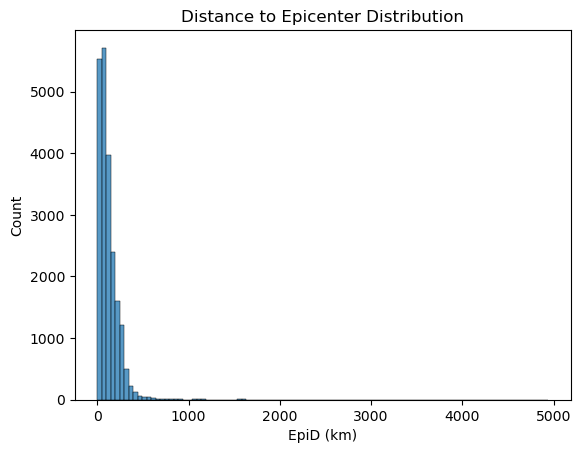

In [93]:
#Majority of the measurements are less than 400km to epicenter
#Consider filtering data to less than 400km
grid = sns.histplot(data=raw_selected, x='EpiD (km)', bins=100).set(title='Distance to Epicenter Distribution')
plt.savefig('images/epicenter_dist.png')

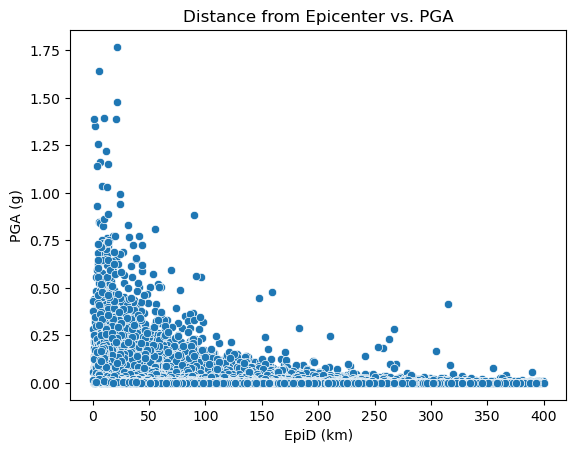

In [94]:
#as we move further away from the epicenter, is PGA dropping? -> yes
less_than_400km = raw_selected[raw_selected['EpiD (km)']<400]
grid = sns.scatterplot(data=less_than_400km, x='EpiD (km)', y='PGA (g)'). set(title='Distance from Epicenter vs. PGA')
plt.savefig('images/epi_pga.png')

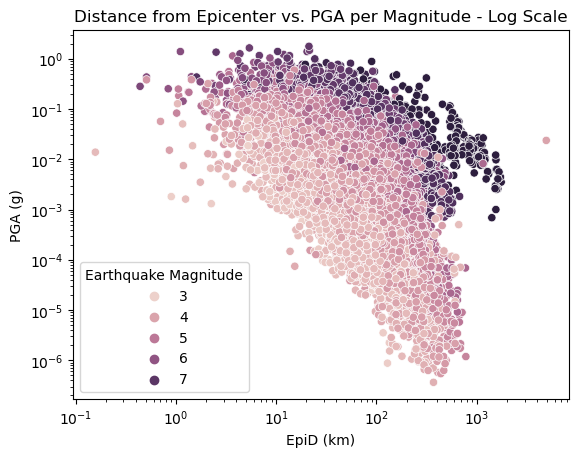

In [95]:
#trying log scale to capture the relationship better (attenuation)
#for a given magnitude, acceleration is dropping away from the epicenter. log scale captures relationship better
grid = sns.scatterplot(data=raw_selected, x='EpiD (km)', y='PGA (g)', hue='Earthquake Magnitude')
grid.set(title='Distance from Epicenter vs. PGA per Magnitude - Log Scale')
grid.set(xscale="log", yscale="log")
plt.savefig('images/epi_pga_mag.png')

In [96]:
#Do not apply additional filters
raw_filtered = raw_selected


## Data Selection

In [97]:
#Now we will select the features that can provide value for our models
#No need to have names, sequence numbers, etc.
analysis_columns = [
    'Earthquake Magnitude',
    'Strike (deg)',
    'Dip (deg)',
    'Rake Angle (deg)',
    'Hypocenter Latitude (deg)',
    'Hypocenter Longitude (deg)',
    'Hypocenter Depth (km)',
    'Depth to Top Of Fault Rupture Model',
    'Fault Rupture Width (km)',
    'Fault Rupture Area (km^2)',
    'EpiD (km)',
    'HypD (km)',
    'ClstD (km)',
    'Vs30 (m/s) selected for analysis',
    'Station Latitude',
    'Station Longitude',
    'PGA (g)'
]

data_for_analysis = raw_filtered[analysis_columns]

## Data Derivation

In [98]:
#add log of columns to capture relationships
data_for_analysis['EpiD log'] = np.log(data_for_analysis['EpiD (km)'])
data_for_analysis['HypD log'] = np.log(data_for_analysis['HypD (km)'])
data_for_analysis['ClstD log'] = np.log(data_for_analysis['ClstD (km)'])
data_for_analysis['Vs30 log'] = np.log(data_for_analysis['Vs30 (m/s) selected for analysis'])

data_for_analysis

,Earthquake Magnitude,Strike (deg),Dip (deg),Rake Angle (deg),Hypocenter Latitude (deg),Hypocenter Longitude (deg),Hypocenter Depth (km),Depth to Top Of Fault Rupture Model,Fault Rupture Width (km),Fault Rupture Area (km^2),...,HypD (km),ClstD (km),Vs30 (m/s) selected for analysis,Station Latitude,Station Longitude,PGA (g),EpiD log,HypD log,ClstD log,Vs30 log
0,6.0,268.0,75.0,160.0,46.61000,-111.96000,6.000,1.974,4.2,68.1,...,8.71000,2.86,593.35,46.5800,-112.0300,0.157020,1.842136,2.164472,1.050822,6.385784
1,6.0,268.0,75.0,160.0,46.62000,-111.97000,6.000,2.039,7.9,120.0,...,8.71000,2.92,551.82,46.5900,-112.0400,0.046423,1.842136,2.164472,1.071584,6.313222
2,5.8,196.2,90.0,0.0,40.40000,-125.10000,10.000,6.449,8.3,74.3,...,74.17000,71.57,219.31,40.5760,-124.2630,0.040961,4.297149,4.306360,4.270676,5.390486
3,5.0,205.5,90.0,0.0,32.90000,-115.21700,16.000,13.082,3.8,8.4,...,36.86000,34.98,213.44,32.7940,-115.5490,0.018449,3.502550,3.607127,3.554776,5.363356
4,5.5,35.0,90.0,0.0,40.30000,-124.80000,10.000,9.507,5.7,25.0,...,55.78000,53.58,219.31,40.5760,-124.2630,0.122180,4.005149,4.021415,3.981176,5.390486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,51.39086,51.11,391.55,37.4037,-122.2387,0.000397,3.925707,3.939460,3.933980,5.970113
21535,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,35.89050,35.63,723.35,37.5823,-122.4201,0.005030,3.551855,3.580473,3.573188,6.583893
21536,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,51.66153,51.36,432.00,37.4037,-122.1760,0.000493,3.931106,3.944713,3.938860,6.068426
21537,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,39.34073,39.13,535.12,37.5864,-122.5022,0.002952,3.648558,3.672260,3.666889,6.282491


## Correlations

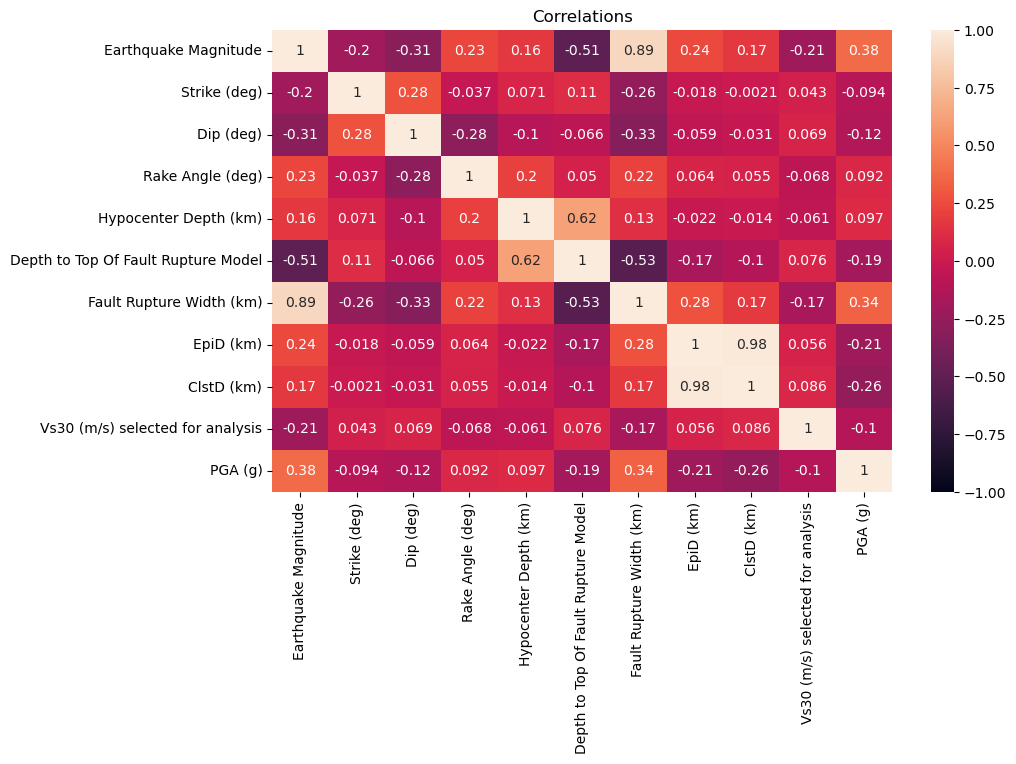

In [99]:
#investigate relationship between various features
correlation_columns = [
    'Earthquake Magnitude',
    'Strike (deg)',
    'Dip (deg)',
    'Rake Angle (deg)',
    'Hypocenter Depth (km)',
    'Depth to Top Of Fault Rupture Model',
    'Fault Rupture Width (km)',
    'EpiD (km)',
    'ClstD (km)',
    'Vs30 (m/s) selected for analysis',
    'PGA (g)'
]

plt.figure(figsize=(10, 6))
sns.heatmap(data_for_analysis[correlation_columns].corr(), vmin=-1, vmax=1, annot=True).set(title='Correlations')
plt.savefig('images/corr.png')

## Renaming Columns for Ease of Use

In [100]:
#prepare data
#rename columns for ease of use
#drop null values

rename_dict = {
    'Earthquake Magnitude':'mag',
    'Strike (deg)':'strike_deg',
    'Dip (deg)':'dip_deg',
    'Rake Angle (deg)':'rake_deg',
    'Hypocenter Latitude (deg)':'hypo_lat',
    'Hypocenter Longitude (deg)':'hypo_long',
    'Hypocenter Depth (km)':'hypo_dep',
    'Depth to Top Of Fault Rupture Model':'rup_dep',
    'Fault Rupture Width (km)':'rup_width',
    'Fault Rupture Area (km^2)':'rup_area',
    'EpiD (km)':'epid',
    'HypD (km)':'hypod',
    'ClstD (km)':'clstd',
    'Vs30 (m/s) selected for analysis':'vs30',
    'Station Latitude':'stat_lat',
    'Station Longitude':'stat_long',
    'PGA (g)':'pga',
    'EpiD log':'epid_log',
    'HypD log':'hypod_log',
    'JoynerD log':'joynerd_log',
    'ClstD log':'clstd_log',
    'Vs30 log':'vs30_log'
}

def prep_data(data, rename_dict):
    result = data.rename(columns=rename_dict)
    result.dropna(inplace=True)
    return result

data = prep_data(data_for_analysis, rename_dict)
data

,mag,strike_deg,dip_deg,rake_deg,hypo_lat,hypo_long,hypo_dep,rup_dep,rup_width,rup_area,...,hypod,clstd,vs30,stat_lat,stat_long,pga,epid_log,hypod_log,clstd_log,vs30_log
0,6.0,268.0,75.0,160.0,46.61000,-111.96000,6.000,1.974,4.2,68.1,...,8.71000,2.86,593.35,46.5800,-112.0300,0.157020,1.842136,2.164472,1.050822,6.385784
1,6.0,268.0,75.0,160.0,46.62000,-111.97000,6.000,2.039,7.9,120.0,...,8.71000,2.92,551.82,46.5900,-112.0400,0.046423,1.842136,2.164472,1.071584,6.313222
2,5.8,196.2,90.0,0.0,40.40000,-125.10000,10.000,6.449,8.3,74.3,...,74.17000,71.57,219.31,40.5760,-124.2630,0.040961,4.297149,4.306360,4.270676,5.390486
3,5.0,205.5,90.0,0.0,32.90000,-115.21700,16.000,13.082,3.8,8.4,...,36.86000,34.98,213.44,32.7940,-115.5490,0.018449,3.502550,3.607127,3.554776,5.363356
4,5.5,35.0,90.0,0.0,40.30000,-124.80000,10.000,9.507,5.7,25.0,...,55.78000,53.58,219.31,40.5760,-124.2630,0.122180,4.005149,4.021415,3.981176,5.390486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21534,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,51.39086,51.11,391.55,37.4037,-122.2387,0.000397,3.925707,3.939460,3.933980,5.970113
21535,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,35.89050,35.63,723.35,37.5823,-122.4201,0.005030,3.551855,3.580473,3.573188,6.583893
21536,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,51.66153,51.36,432.00,37.4037,-122.1760,0.000493,3.931106,3.944713,3.938860,6.068426
21537,3.6,151.0,88.0,-177.0,37.86037,-122.23589,8.465,7.920,0.8,0.8,...,39.34073,39.13,535.12,37.5864,-122.5022,0.002952,3.648558,3.672260,3.666889,6.282491


In [101]:
#Prepare train and test data

def prep_train_test_data(input_data, columns):
    X = input_data[columns]
    y = input_data['pga']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [102]:
#a function that trains the model and returns results ready for consumption
def run_model_get_results(X_train, X_test, y_train, y_test, model):
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
        
    pipe.fit(X_train, y_train)
        
    training_mae = mean_absolute_error(y_train, pipe.predict(X_train))
    test_mae = mean_absolute_error(y_test, pipe.predict(X_test))
    
    pred = pipe.predict(X_test)
        
    results = X_test.copy()
    
    results['pga_actual'] = y_test
    results['pga_predicted'] = pred
    results['pga_error'] = y_test - pred
        
    return training_mae, test_mae, results    

# Modeling

## Baseline Model
Build a baseline model to compare against.
We will use a linear regression model that captures main relationships between magnitude, distance to epicenter and depth of the earthquake

In [103]:
#Track model names, models and error for final evaluation
model_names = []
models = []
training_maes = []
test_maes = []

#columns to use for baseline
baseline_columns = ['mag', 'epid', 'vs30']
X_train, X_test, y_train, y_test = prep_train_test_data(data, baseline_columns)

Training MAE:	 0.03193316310353517
Test MAE:	 0.032135751610641416


[Text(0.5, 1.0, 'Predicted PGA vs. Magnitude')]

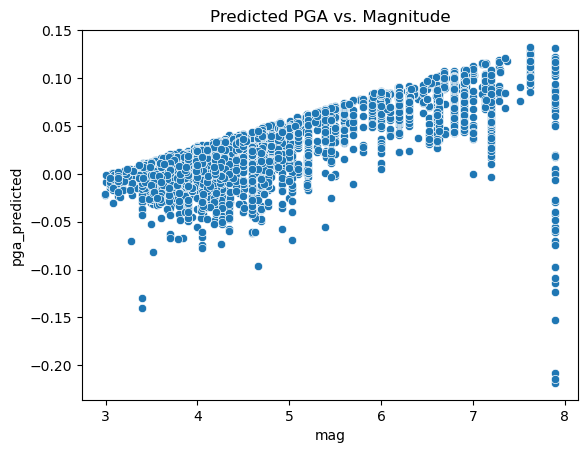

In [104]:
#Use LinearRegression as the base model
model = LinearRegression()
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('LinReg-Baseline')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

sns.scatterplot(data=results, x='mag', y='pga_predicted').set(title='Predicted PGA vs. Magnitude')

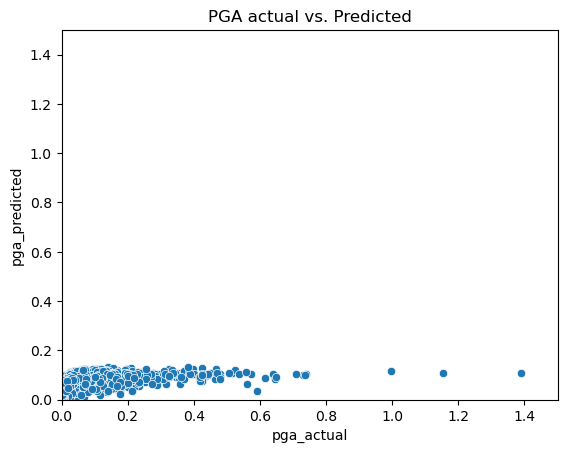

In [105]:
#predictions are deviating from actual for higher values
fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)
plt.savefig('images/base_actual_pred.png')

## Feature Selection
Use Lasso to select most important features

In [106]:
#include all input columns, full data, for feature selection
all_input_columns = data.columns.drop('pga')
X = data[all_input_columns]
y = data['pga']

#Use L1 regularization for feature selection
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=500000))
])

params = {"lasso__alpha":np.arange(0.00001, 10, 500)}

#Use grid search to find best Lasso model
lasso_cv=GridSearchCV(lasso_pipe, param_grid=params, cv=5)
lasso_cv.fit(X, y)

print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'lasso__alpha': 1e-05}


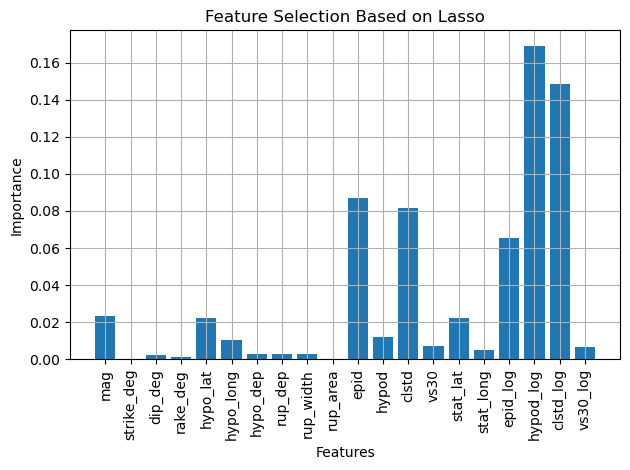

In [107]:
col_names=X.columns

#Using np.abs() to make coefficients positive  
best_coef = np.abs(lasso_cv.best_estimator_.named_steps['lasso'].coef_)

#Plotting the Column Names and Importance of Columns. 
plt.bar(col_names, best_coef)
plt.xticks(rotation=90)
plt.grid()

plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig('images/feat_select.png')
plt.show()


## Alternative Models

### Linear Regression Based on Most Important Columns

Training MAE:	 0.02504502457170235
Test MAE:	 0.02539021262137588


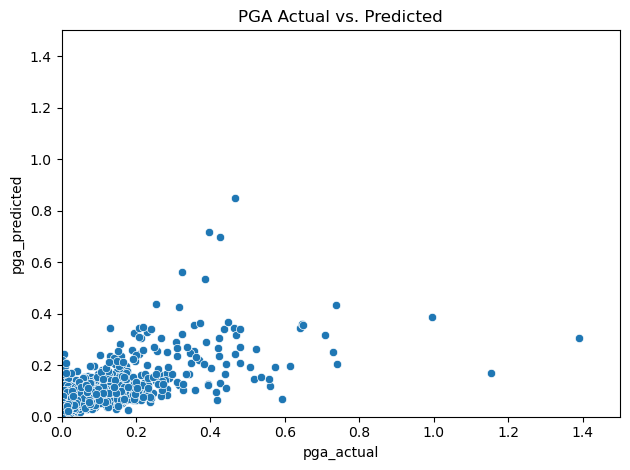

In [108]:
#Linear regression based on most important features
important_features = [
    'mag',
    'hypo_lat',
    'epid',
    'clstd',
    'stat_lat',
    'epid_log',
    'hypod_log',
    'clstd_log'
]

X_train, X_test, y_train, y_test = prep_train_test_data(data, important_features)

model = LinearRegression()
models.append(model)
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('LinReg-Features')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

#predictions are deviating from actual for higher values
fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)
plt.tight_layout()
plt.savefig('images/linreg_actual_pred.png')
plt.show()


### KN Regressor

Training MAE:	 0.010535799778011626
Test MAE:	 0.01315740138256727


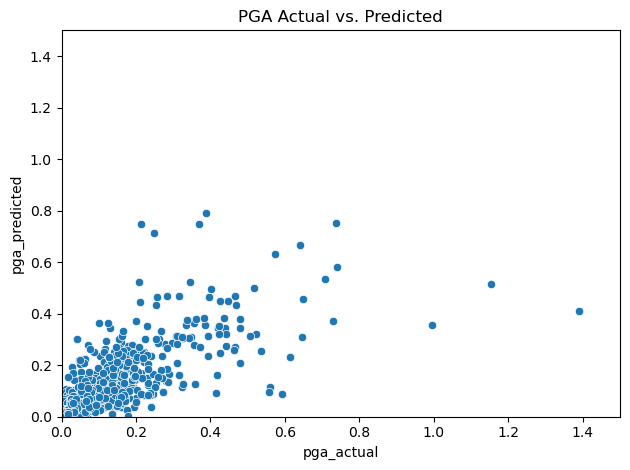

In [109]:
#K-Nearest Neighbor Regressor

important_features = [
    'mag',
    'hypo_lat',
    'epid',
    'clstd',
    'stat_lat',
    'epid_log',
    'hypod_log',
    'clstd_log'
]

model = KNeighborsRegressor(n_neighbors=5)
models.append(model)
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('KNR-Features')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)


fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/knr_actual_pred.png')

### Elastic Net

Training MAE:	 0.03828036294307838
Test MAE:	 0.03834414183451453


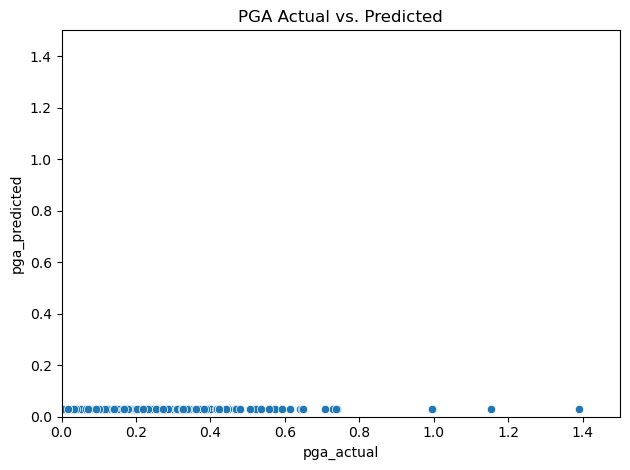

In [110]:
#Elastic Net
model = ElasticNet(alpha=0.1)
models.append(model)
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('ElasticNet-Features')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/elastic_actual_pred.png')

### Neural Network

Training MAE:	 0.01632816652634039
Test MAE:	 0.016703870689058906


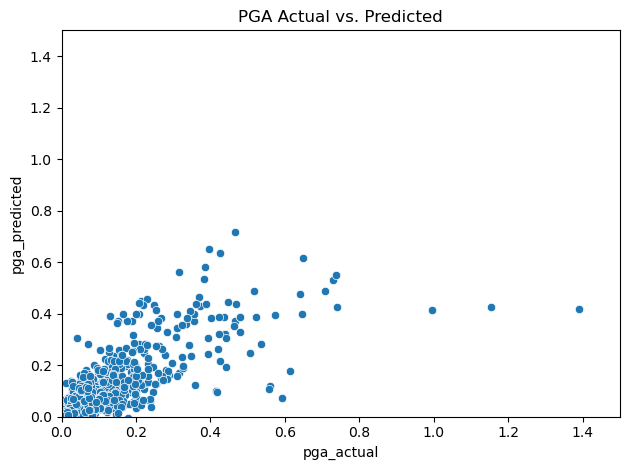

In [111]:
#NeuralNetwork
model = MLPRegressor(max_iter=10000, hidden_layer_sizes=(10, 100, 100))
models.append(model)
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('MLPRegressor-Features')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)
                   
print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/neural_actual_pred.png')

### Neural Network with all columns

Training MAE:	 0.01648491706494868
Test MAE:	 0.017253466175894187


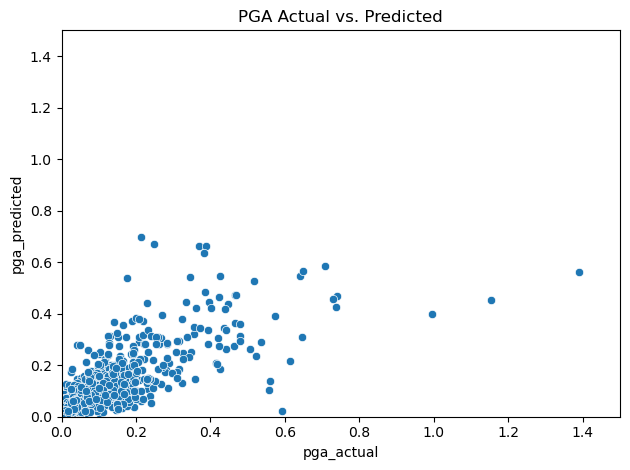

In [112]:
#Neural Network with All Columns
X_train, X_test, y_train, y_test = prep_train_test_data(data, all_input_columns)

model = MLPRegressor(max_iter=10000, hidden_layer_sizes=(10, 100, 100))
models.append(model)
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Add to stats
model_names.append('MLPRegressor-All Features')
models.append(model)
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/neural_all_actual_pred.png')

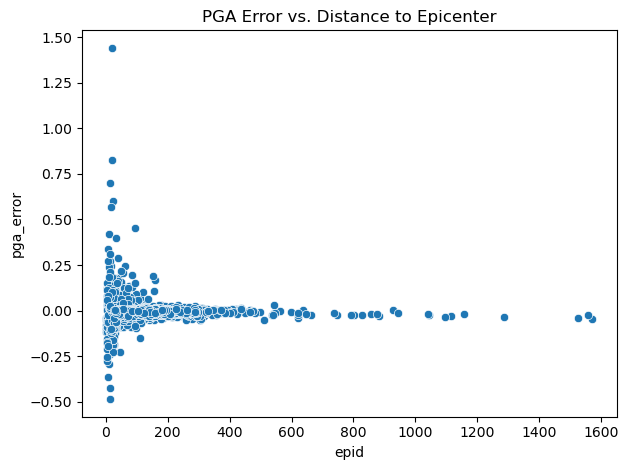

In [113]:
sns.scatterplot(data=results, x='epid', y='pga_error').set(title='PGA Error vs. Distance to Epicenter')
plt.tight_layout()
plt.savefig('images/neural_pgaerror_epi.png')

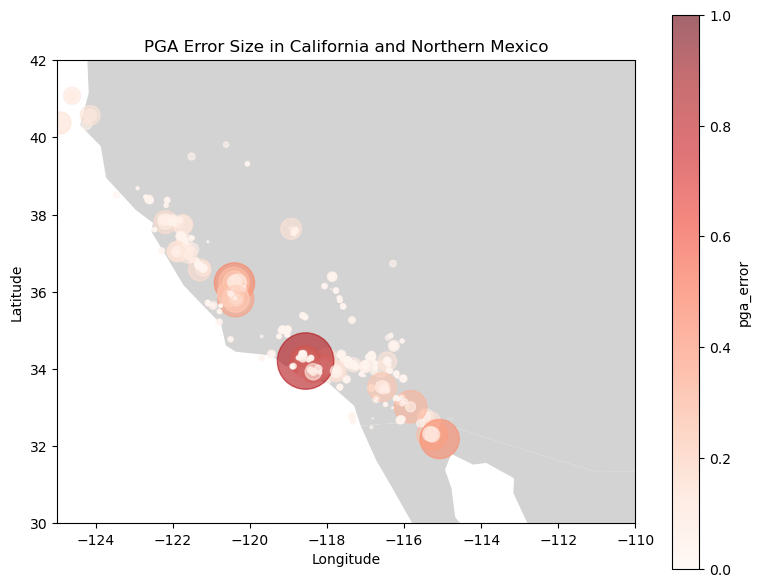

In [114]:
#Plot California region modeling error on a map
import geopandas as gpd

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(8, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting error data with a color map
x = results['hypo_long']
y = results['hypo_lat']
z = results['pga_error']
plt.scatter(x, y, s=2000*z, c=z, alpha=0.6, vmin=0, vmax=1, cmap='Reds')
plt.colorbar(label='pga_error')

plt.xlim([-125, -110])
plt.ylim([30, 42])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title('PGA Error Size in California and Northern Mexico')

plt.tight_layout()
plt.savefig('images/cali.png')

plt.show()



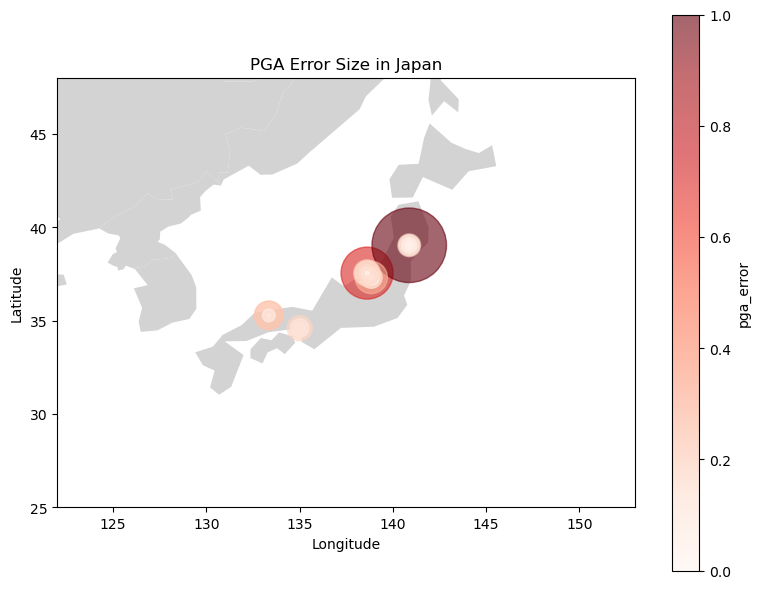

In [115]:
#Plot Japan region modeling error on a map

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(8, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = results['hypo_long']
y = results['hypo_lat']
z = results['pga_error']
plt.scatter(x, y, s=2000*z, c=z, alpha=0.6, vmin=0, vmax=1, cmap='Reds')
plt.colorbar(label='pga_error')

plt.xlim([122, 153])
plt.ylim([25, 48])

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.title('PGA Error Size in Japan')

plt.tight_layout()
plt.savefig('images/japan.png')

plt.show()


### Optimize KNRegressor

In [116]:
#KN Regressor with Grid Search for optimization
parameters_to_try = {'knn__n_neighbors':[3,5,10,20],
                     'knn__weights':['uniform', 'distance'],
                     'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                     'knn__leaf_size':[5,10,20,30,40,50,100],
                     'knn__p':[1,2],
                     'knn__n_jobs':[-1]
}

X_train, X_test, y_train, y_test = prep_train_test_data(data, important_features)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

knn_cv = GridSearchCV(knn, param_grid=parameters_to_try, cv=5)
knn_cv.fit(X_train, y_train)
print("Best Params {}".format(knn_cv.best_params_))

Best Params {'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__n_jobs': -1, 'knn__n_neighbors': 20, 'knn__p': 2, 'knn__weights': 'distance'}


Training MAE:	 9.743906867061978e-05
Test MAE:	 0.012715477773232177


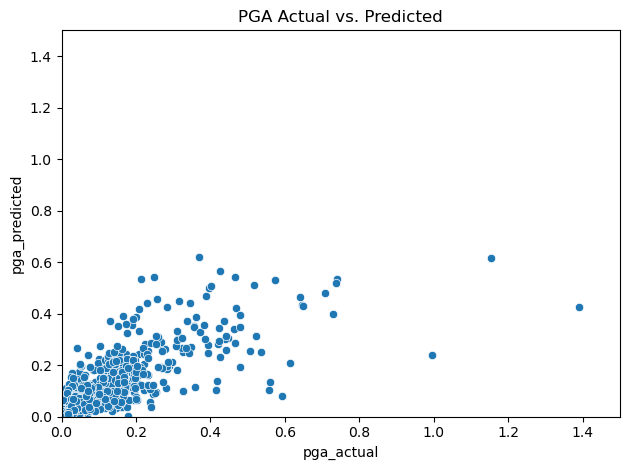

In [117]:
#Chose best estimator
model = knn_cv.best_estimator_
models.append(model.named_steps['knn'])
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Update stats
model_names.append('KNR-Optimized')
models.append(model.named_steps['knn'])
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/knr_opt_actual_pred.png')

### Optimize KNRegressor based on civil engineer inputs

Best Params {'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__n_jobs': -1, 'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance'}
Training MAE:	 9.059888784516332e-05
Test MAE:	 0.013122442545287844


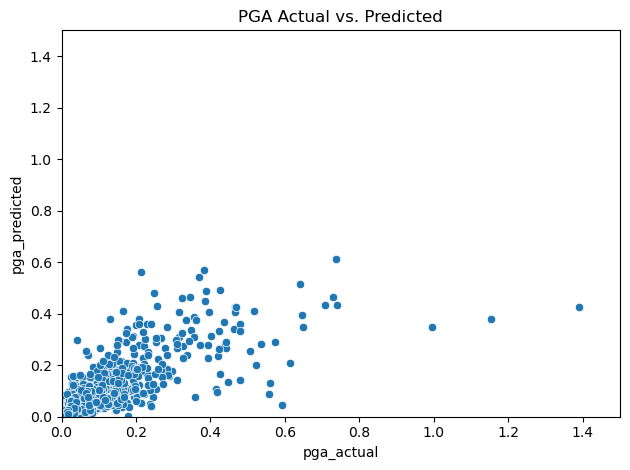

In [118]:
#KN Regressor with expert engineer inputs

#Expert suggested columns
engineer_features = ['mag',
                     'epid_log',
                     'hypod_log',
                     'clstd_log',
                     'vs30_log'
]

parameters_to_try = {'knn__n_neighbors':[3,5,10,20],
                     'knn__weights':['uniform', 'distance'],
                     'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                     'knn__leaf_size':[5,10,20,30,40,50,100],
                     'knn__p':[1,2],
                     'knn__n_jobs':[-1]
}

#Prep train and test data
X_train, X_test, y_train, y_test = prep_train_test_data(data, engineer_features)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

#Grid search on variables
knn_cv = GridSearchCV(knn, param_grid=parameters_to_try, cv=5)
knn_cv.fit(X_train, y_train)
print("Best Params {}".format(knn_cv.best_params_))
    
model = knn_cv.best_estimator_
models.append(model.named_steps['knn'])
training_mae, test_mae, results = run_model_get_results(X_train, X_test, y_train, y_test, model)

#Update stats
model_names.append('KNR-Eng. Optimized')
models.append(model.named_steps['knn'])
training_maes.append(training_mae)
test_maes.append(test_mae)

print('Training MAE:\t', training_mae)
print('Test MAE:\t', test_mae)

fig, ax = plt.subplots()
sns.scatterplot(data=results, x='pga_actual', y='pga_predicted', ax=ax).set(title='PGA Actual vs. Predicted')
ax.set_xlim(0,1.5)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('images/knr_opt_eng_actual_pred.png')


# Evaluation

In [119]:
#Prepare and summarize all results at once
result_frame = pd.DataFrame({'Model':model_names,
                             'Training MAE':training_maes,
                             'Test MAE':test_maes})
    
result_frame

,Model,Training MAE,Test MAE
0,LinReg-Baseline,0.031933,0.032136
1,LinReg-Features,0.025045,0.025390
2,KNR-Features,0.010536,0.013157
3,ElasticNet-Features,0.038280,0.038344
4,MLPRegressor-Features,0.016328,0.016704
5,MLPRegressor-All Features,0.016485,0.017253
6,KNR-Optimized,0.000097,0.012715
7,KNR-Eng. Optimized,0.000091,0.013122


# Results

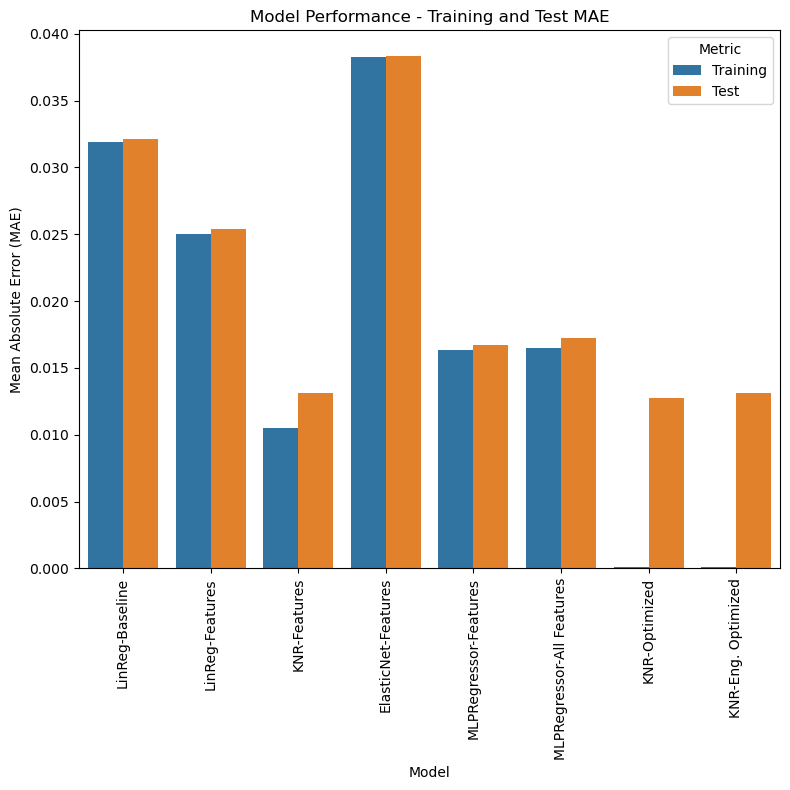

In [120]:
#Convert the results to a dataframe that can be used for the plot
results_for_plot = pd.DataFrame()
results_for_plot['Model'] = result_frame['Model']
results_for_plot['Metric'] = 'Training'
results_for_plot['Mean Absolute Error (MAE)'] = result_frame['Training MAE']

for i in range(8):
        results_for_plot.loc[len(results_for_plot)] = results_for_plot.loc[i]
        results_for_plot.loc[i+8, 'Metric'] = 'Test'
        results_for_plot.loc[i+8, 'Mean Absolute Error (MAE)'] = result_frame.loc[i, 'Test MAE']

#Plot results for comparative analysis
fig = plt.figure(figsize=(8, 8))
sns.barplot(data=results_for_plot, x='Model', y='Mean Absolute Error (MAE)', hue='Metric').set(title='Model Performance - Training and Test MAE')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/model_mae.png')